In [ ]:
from scipy import stats, linalg
import numpy as np
import pandas as pd
import os
from scipy.special import logsumexp, logit, softmax
from scipy.special import gamma as gammafunc
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns   
from scipy.stats import invweibull
from scipy.integrate import quad

In [ ]:
def generate_next_timepoint(m, k, w, mu, gamma, nu, zeta, S, dt, rng=None):
    """
    Simulates the transitions between the homozygous demtheylated, heterozygous
    and homozygous methylated states in a time step dt in a pool of S cells.

    Arguments:
        m: number of homozygous methylated cells - array of the ints
        k: number of heterozygous methylated cells - array of the ints
        w: number of homozygous demethylated cells - array of the ints
        mu: rate to transition from homozygous demethylated to heterozygous
            - float >= 0
        gamma: rate to transition from homozygous methylated to heterozygous
            - float >= 0
        nu: rate to transition from heterozygous to homozygous methylated
            - float >= 0
        zeta: rate to transition from heterozygous to homozygous demethylated
            - float >= 0         
        S: total number of cells all(m + k + w == S) - int
        dt: time step - float > 0
        rng: np.random.default_rng() object, Optional
    Returns:
        Updated m, k, w after transitions have occurred
    """

    if rng is None:
        rng = np.random.default_rng()

    NSIM = len(m)

    # Use sequential rounds of binomial sampling to calculate how many cells
    # transition between each state
    m_to_k, k_out, w_to_k = rng.binomial(
                                    n = (m, k, w), 
                                    p = np.tile([2*gamma*dt, 
                                        (nu + zeta)*dt, 2*mu*dt], [NSIM, 1]).T)

    k_to_m = rng.binomial(n=k_out, p = np.repeat(nu / (nu + zeta), NSIM))

    m = m - m_to_k + k_to_m
    k = k - k_out + m_to_k + w_to_k
    w = S - m - k

    return (m, k, w)

In [ ]:
def multinomial_rvs(counts, p, rng=None):
    """
    Simulate multinomial sampling of D dimensional probability distribution

    Arguments:
        counts: number of draws from distribution - int or array of the 
                ints (N)
        p: probability  - array of the floats (D, N)
        rng: np.random.default_rng() object, Optional
    Returns:
        Multinomial sample
    """

    if rng is None:
        rng = np.random.default_rng()

    if not isinstance(counts, (np.ndarray)):
        counts = np.full(p[0, ...].shape, counts)

    out = np.zeros(np.shape(p), dtype=int)
    ps = np.cumsum(p[::-1, ...], axis=0)[::-1, ...]
    # Conditional probabilities
    with np.errstate(divide='ignore', invalid='ignore'):
        condp = p / ps
    condp[np.isnan(condp)] = 0.0

    for i in range(p.shape[0]-1):
        binsample = rng.binomial(counts, condp[i, ...])
        out[i, ...] = binsample
        counts -= binsample

    out[-1, ...] = counts

    return out

In [ ]:
def initialise_cancer(tau, mu, gamma, nu, zeta, NSIM, rng=None, init = None):
    """
    Initialise a cancer, assigning fCpG states assuming fCpGs are homozygous 
    at t=0

    Arguments:
        tau: age when population began expanding exponentially - float
        mu: rate to transition from homozygous demethylated to heterozygous
            - float >= 0
        gamma: rate to transition from homozygous methylated to heterozygous
            - float >= 0
        nu: rate to transition from heterozygous to homozygous methylated
            - float >= 0
        zeta: rate to transition from heterozygous to homozygous demethylated
            - float >= 0         
        NSIM: number of fCpG loci to simulate - int
        rng: np.random.default_rng() object, Optional
        init: allowed values 0, 1, 2 or None. If None, initialise assuming
                time cancer began at time time tau, otherwise initailise in 
                0: w, 1: k, or 2: m. 
    Returns:
        m_cancer, k_cancer, w_cancer: number of homo meth, hetet meth and 
                homo unmeth cells in the population - np.array[int]
    """

    if rng is None:
        rng = np.random.default_rng()

    if init is None:
        # assume fCpG's are homozygous methylated at t=0
        mkw = np.zeros((3, NSIM), dtype = int)
        idx = np.arange(NSIM)
        np.random.shuffle(idx)
        mkw[0, idx[:NSIM//2]] = 1
        mkw[2, idx[NSIM//2:]] = 1

        # generate distribution of fCpG loci when population begins growing 
        # at t=tau
        RateMatrix = np.array([[-2*gamma, nu, 0], 
                                [2*gamma, -(nu+zeta), 2*mu], 
                                [0, zeta, -2*mu]])

        ProbStates = linalg.expm(RateMatrix * tau) @ mkw

        m_cancer, k_cancer, w_cancer = multinomial_rvs(1, ProbStates, rng)
    
    elif init in [0, 1, 2]:
        wkm = np.zeros((3, NSIM), dtype = int)
        wkm[init, :] = 1

        w_cancer, k_cancer, m_cancer = wkm

    else:
        raise ValueError('init must be None or 0, 1 or 2')

    return m_cancer, k_cancer, w_cancer

In [ ]:
def grow_cancer(m_cancer, k_cancer, w_cancer, S_cancer_i, S_cancer_iPlus1, rng):
    """
    Grow a cancer, assigning fCpG states according to a multinomial ditribution

    Arguments:
        m_cancer, k_cancer, w_cancer: number of homo meth, hetet meth and 
                homo unmeth cells in the population - np.array[int]
        S_cancer_i: number of cells at time t - int = m_cancer + k_cancer + w_cancer
        S_cancer_iPlus1: number of cells at time t+dt - int >= S_cancer_i
        rng: np.random.default_rng() object, Optional
    Returns:
        Updated m_cancer, k_cancer, w_cancer
    """

    if rng is None:
        rng = np.random.default_rng()

    if S_cancer_iPlus1 - S_cancer_i > 0:
        prob_matrix = np.stack((m_cancer, k_cancer, w_cancer)) / S_cancer_i
        growth = multinomial_rvs(S_cancer_iPlus1 - S_cancer_i, prob_matrix, rng)

        m_cancer += growth[0, :]
        k_cancer += growth[1, :]
        w_cancer += growth[2, :]

    return m_cancer, k_cancer, w_cancer

In [ ]:
def stochastic_growth(theta, tau, mu, gamma, nu, zeta, T, NSIM, init = None):
    """
    Simulate the methylation distribution of fCpG loci for an exponentially 
    growing well-mixed population evolving neutrally

    Arguments:
        theta: exponential growth rate of population - float
        tau: age when population began expanding exponentially - float < T
        mu: rate to transition from homozygous demethylated to heterozygous
            - float >= 0
        gamma: rate to transition from homozygous methylated to heterozygous
            - float >= 0
        nu: rate to transition from heterozygous to homozygous methylated
            - float >= 0
        zeta: rate to transition from heterozygous to homozygous demethylated
            - float >= 0         
        T: patient's age - float
        NSIM: number of fCpG loci to simulate - int
    Returns:
        betaCancer: fCpG methylation fraction distribution - np.array[float]
    """

    # calculate the time step so all transition probabilities are <= 10%
    dt_max = 0.01 / np.max((
        2*gamma, 
        2*mu,
        2*nu,
        2*zeta,
        theta)
    )
    
    # calculate deterministic exponential growth population size
    n = int((T-tau) / dt_max) + 2  # Number of time steps.
    t = np.linspace(tau, T, n) 
    dt = t[1] - t[0]
    S_cancer = np.exp(theta * (t-tau)).astype(int)

    if np.any(S_cancer < 0):
        raise(OverflowError('overflow encountered for S_cancer'))

    rng = np.random.default_rng()

    # generate distribution of fCpG loci depending on init param
    m_cancer, k_cancer, w_cancer = initialise_cancer(tau, mu, gamma, nu, zeta, 
                                                     NSIM, rng, init)

    # simulate changes to methylation distribution by splitting the process 
    # into 2 phases, an exponential growth phase and a methylation transition 
    # phase
    for i in range(len(t)-1):
        m_cancer, k_cancer, w_cancer = grow_cancer(m_cancer, k_cancer,
                                                    w_cancer, S_cancer[i], 
                                                    S_cancer[i+1], rng)

        m_cancer, k_cancer, w_cancer = generate_next_timepoint(m_cancer, 
                                                    k_cancer, w_cancer, 
                                                    mu, gamma, nu, zeta,
                                                    S_cancer[i+1], dt, rng)

    with np.errstate(divide='raise', over='raise'):
        betaCancer = (k_cancer + 2*m_cancer) / (2*S_cancer[-1])

    return betaCancer

In [ ]:
def calculate_mixing_weight_lpmf(mu, gamma, nu, zeta, tau):
    # generate distribution of fCpG loci when population begins growing 
    # at t=tau
    RateMatrix = np.array([[-2*gamma, nu, 0], 
                            [2*gamma, -(nu+zeta), 2*mu], 
                            [0, zeta, -2*mu]])
    
    # assume population is either homozygous methylated or demethylated at t=0
    mkw = np.array([0.5, 0, 0.5]).T

    # use matrix exponentiation to solve to for the mixing weights
    ProbStates = linalg.expm(RateMatrix * tau) @ mkw

    return np.log(ProbStates)

In [ ]:
def calculate_frechet_parameters(mut_rate, theta, deltaT):

    a = np.exp(1) / 2
    m_norm = 0.5 * mut_rate / theta * (theta * deltaT + np.log(mut_rate / theta ) - (1 + a))
    s_norm = 0.5 * np.exp(1) * mut_rate / theta

    return a, m_norm, s_norm

In [ ]:
def demeth_homo_init_lpdf(y, theta, mu, tau, T):

    a, m_norm, s_norm = calculate_frechet_parameters(2 * mu, theta, T - tau)

    return invweibull.logpdf(y, a, loc = m_norm, scale = s_norm)

In [ ]:
def meth_homo_init_lpdf(y, theta, gamma, tau, T):

    a, m_norm, s_norm = calculate_frechet_parameters(2 * gamma, theta, T - tau)

    return invweibull.logpdf(1-y, a, loc = m_norm, scale = s_norm)

In [ ]:
def hetero_integrand(x, z, theta, nu, zeta, tau, T):

    a, m1_norm, s1_norm = calculate_frechet_parameters(nu, theta, T - tau)
    a, m2_norm, s2_norm = calculate_frechet_parameters(zeta, theta, T - tau)

    return np.exp(invweibull.logpdf(x, a, loc = m2_norm, scale = s2_norm) 
                  + invweibull.logpdf(z-0.5+x, a, loc = m1_norm, scale = s1_norm))

In [ ]:
def meth_hetero_init_lpdf(y, theta, nu, zeta, tau, T):
    
    if isinstance(y, (list, tuple, np.ndarray)):
        integral = np.array([quad(hetero_integrand, 0, 1, 
                                args=(y_i, theta, nu, zeta, tau, T))[0]
                            for y_i in y])
    else:
        integral = quad(hetero_integrand, 0, 1, 
                            args=(y, theta, nu, zeta, tau, T))[0]

    return np.log(integral)

In [ ]:
def combined_lpdf(y, theta, tau, mu, gamma, nu, zeta, T):

    mixing_lpdf = calculate_mixing_weight_lpmf(mu, gamma, nu, zeta, tau)

    left_peak = demeth_homo_init_lpdf(y, theta, mu, tau, T)
    central_peak = meth_hetero_init_lpdf(y, theta, nu, zeta, tau, T)
    right_peak = meth_homo_init_lpdf(y, theta, gamma, tau, T)

    # Combine using logsumexp: log(w1*p1 + w2*p2 + w3*p3) = 
    # logsumexp([log(w1)+log(p1), log(w2)+log(p2), log(w3)+log(p3)])
    log_weighted_components = np.array([
        mixing_lpdf[0] + right_peak,    # log(w1) + log(p1) for demethylated homozygous
        mixing_lpdf[1] + central_peak, # log(w2) + log(p2) for heterozygous  
        mixing_lpdf[2] + left_peak    # log(w3) + log(p3) for methylated homozygous
    ])
    
    # Use logsumexp to compute the final combined log probability density
    combined_lpdf = logsumexp(log_weighted_components, axis=0)

    return combined_lpdf

In [ ]:
def fit_landau_rvs(beta):
    loc, scale = stats.landau.fit(beta)
    return stats.landau.rvs(loc, scale, size=10000)

In [ ]:
from scipy.linalg import expm


def analytic_calculation(t, theta, mu, gamma, nu, zeta):
    B = np.array([[theta - 2 * gamma, nu, 0], [2 * gamma, theta - (nu + zeta), 2 * mu], [0, zeta, theta - 2 * mu]])

    exponential = expm(t * B)

    return (exponential[0, :] + 0.5 * exponential[1, :]) / np.exp(t * theta)

In [ ]:
def calculate_scaling_factor(beta):
    hist = np.histogram(beta, bins=np.linspace(0, 1, 201), density=True)
    nondense_hist = np.histogram(beta, bins=np.linspace(0, 1, 201), density=False)
    prop = np.max(nondense_hist[0])/np.sum(nondense_hist[0])
    scale = np.max(hist[0])/prop

    return scale

In [ ]:
def calculate_spike_height(beta, mu, theta):
    scale = calculate_scaling_factor(beta)

    return 2 * scale * mu * np.log(2)/theta

In [ ]:
T = 50
tau = 45
theta = 2.4
mu = 0.04
gamma = 1e-12
nu = 1e-12
zeta = 1e-12

init = 0

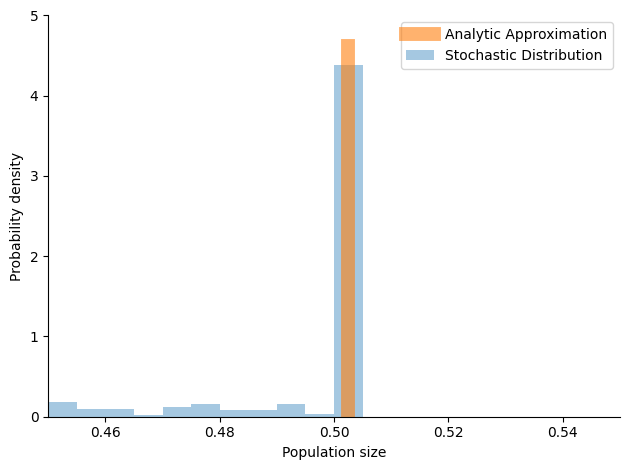

In [ ]:
betaCancer = stochastic_growth(theta, tau, mu, gamma, nu, zeta, T, 10000, init)

x = np.linspace(0, 1, 1001)
# pdf = np.exp(combined_lpdf(x, theta, tau, mu, gamma, nu, zeta, T))

fig, ax = plt.subplots()
# frechet = stats.invweibull.rvs(*calculate_frechet_parameters(2*mu, theta, T-tau), size=10000)
# plt.hist(frechet, bins = np.linspace(0, 1, 201), 
        #  alpha = 0.4, density = True)


spike = calculate_spike_height(betaCancer, mu, theta)

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot([0.5025, 0.5025], [0, spike], alpha=0.6, linewidth=10)
# plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.xlim(0.45, 0.55)
plt.ylim(0, 5)
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()

In [ ]:
from tqdm import tqdm

mu_vals = np.logspace(-5, -0.2, num=50)
mu_means = []
mu_vars = []

for mu_val in tqdm(mu_vals):
    betaPeak = stochastic_growth(theta, tau, mu_val, gamma, nu, zeta, T, 10000, init)
    mu_means.append(np.mean(betaPeak[np.argwhere(betaPeak != 0.5)]))    # Exclude the spike from the calculation of the mean
    mu_vars.append(np.var(betaPeak[np.argwhere(betaPeak != 0.5)]))


100%|██████████| 50/50 [01:20<00:00,  1.62s/it]


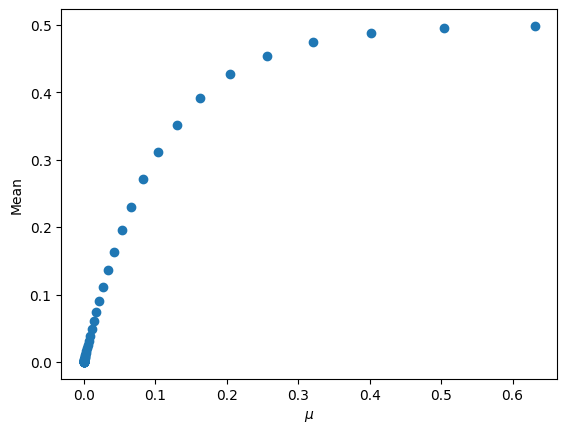

In [ ]:
plt.scatter(mu_vals, mu_means)
plt.xlabel(r'$\mu$')
plt.ylabel("Mean")
plt.show()

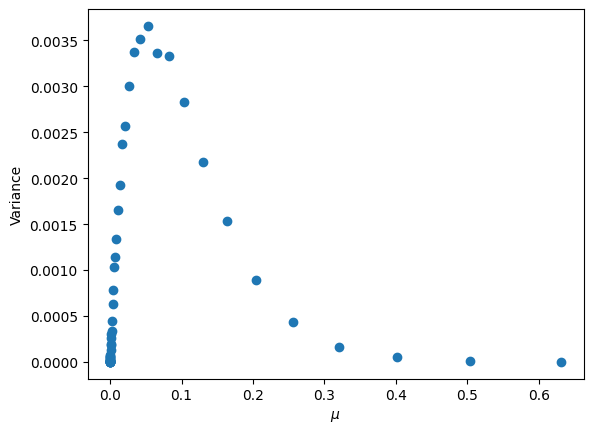

In [ ]:
plt.scatter(mu_vals, mu_vars)
plt.xlabel(r'$\mu$')
plt.ylabel("Variance")
plt.show()

In [ ]:
tau_vals = np.linspace(0.83, 1.0, num=50)
tau_means = []
tau_vars = []

for tau_val in tqdm(tau_vals):
    betaPeak = stochastic_growth(theta, tau_val * T, mu, gamma, nu, zeta, T, 10000, init)
    tau_means.append(np.mean(betaPeak[np.argwhere(betaPeak != 0.5)]))    # Exclude the spike from the calculation of the mean
    tau_vars.append(np.var(betaPeak[np.argwhere(betaPeak != 0.5)]))

  2%|▏         | 1/50 [00:02<02:16,  2.79s/it]


KeyboardInterrupt: 

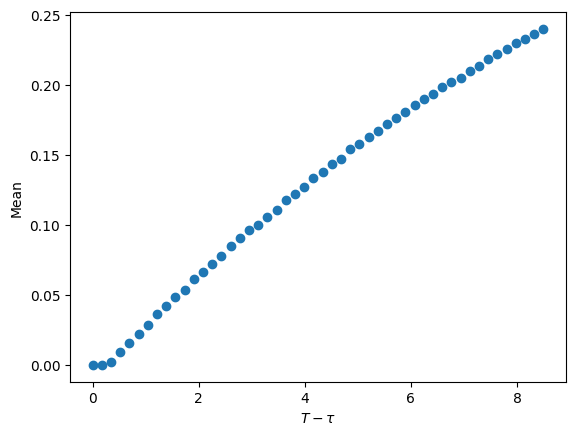

In [ ]:
plt.scatter(T-tau_vals*T, tau_means)
plt.xlabel(r'$T-\tau$')
plt.ylabel("Mean")
plt.show()

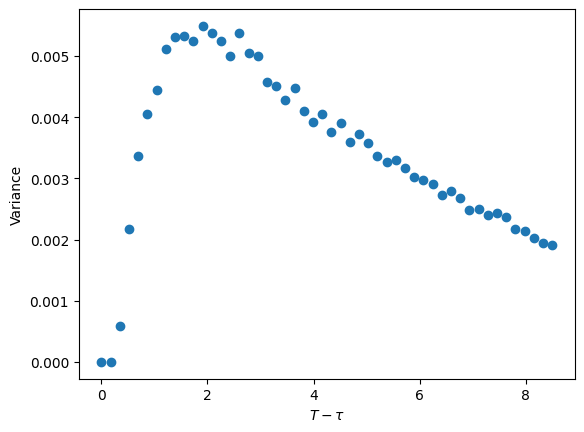

In [ ]:
plt.scatter(T-tau_vals*T, tau_vars)
plt.xlabel(r'$T-\tau$')
plt.ylabel("Variance")
plt.show()

In [ ]:
mu_vals_short = np.logspace(-5, -0.2, num=25)
tau_vals_short = np.linspace(0.83, 1.0, num=25)

mean_val_grid = np.zeros((len(mu_vals_short), len(tau_vals_short)))
var_val_grid = np.zeros((len(mu_vals_short), len(tau_vals_short)))

for i in tqdm(range(len(mu_vals_short))):
    for j in range(len(tau_vals_short)):
        betaPeak = stochastic_growth(theta, tau_vals_short[j] * T, mu_vals_short[i], gamma, nu, zeta, T, 10000, init)
        mean_val_grid[i, j] = (np.mean(betaPeak[np.argwhere(betaPeak != 0.5)]))    # Exclude the spike from the calculation of the mean
        var_val_grid[i, j] = (np.var(betaPeak[np.argwhere(betaPeak != 0.5)]))

100%|██████████| 25/25 [16:21<00:00, 39.25s/it]


In [ ]:
import pickle

f = open('pickles/mean_val_grid.pkl', 'wb')
pickle.dump(mean_val_grid, f)
f.close()

f = open('pickles/var_val_grid.pkl', 'wb')
pickle.dump(var_val_grid, f)
f.close()

In [ ]:
def logistic(x, a, b, c, d):
    mu, tau_rel = x
    tau = T*tau_rel
    return (a*(mu*(T-tau))**b)/(1+c*(mu*(T-tau))**d)

In [ ]:
from scipy.optimize import curve_fit

tautau, mumu = np.meshgrid(tau_vals_short, mu_vals_short)
mu_flat = mumu.flatten().T
tau_flat = tautau.flatten().T
results_flat = mean_val_grid.flatten().T

xdata = (mu_flat, tau_flat)
p0 = (2, 0.9, 2, 0.5)

params, cov = curve_fit(logistic, xdata, results_flat, p0=p0)

a, b, c, d = params
print(f"a={a}, b={b}, c={c}, d={d}")

a=0.8782666188029277, b=1.0187175689315142, c=1.1178948089321472, d=1.237734876595793


In [ ]:
y_pred = logistic(xdata, *params)

# Calculate R^2 score
ss_res = np.sum((results_flat - y_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((results_flat - np.mean(results_flat)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

print(f"R^2 = {r2:.4f}")

R^2 = 0.9953


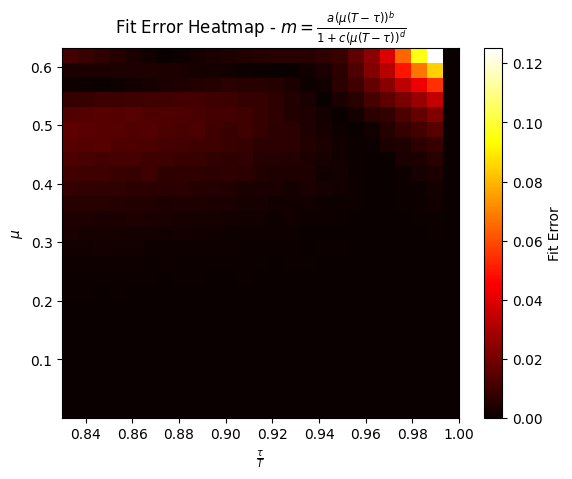

In [ ]:
plt.imshow(np.absolute(y_pred.reshape(mean_val_grid.shape) - mean_val_grid), 
           aspect="auto",
            cmap="hot",
            origin="lower",
            extent=[tau_vals_short[0], tau_vals_short[-1], mu_vals_short[0], mu_vals_short[-1]],)
plt.colorbar(label=r"Fit Error")
plt.xlabel(r"$\frac{\tau}{T}$")
plt.ylabel(r"$\mu$")
plt.title(r"Fit Error Heatmap - $m=\frac{a(\mu(T-\tau))^b}{1+c(\mu(T-\tau))^d}$")
plt.show()

In [ ]:
def bell_guess(x, p, q, r):
    mu, tau_rel = x
    tau = T*tau_rel
    com = mu*(T-tau)
    return com**p*np.exp(-q*com**r)

In [ ]:
var_results_flat = var_val_grid.flatten().T

xdata = (mu_flat, tau_flat)
p0 = (4, 4, 4)

params_var, cov_var = curve_fit(bell_guess, xdata, var_results_flat, p0=p0)

In [ ]:
y_pred_var = bell_guess(xdata, *params_var)

# Calculate R^2 score
ss_res = np.sum((var_results_flat - y_pred_var) ** 2)  # Residual sum of squares
ss_tot = np.sum((var_results_flat - np.mean(var_results_flat)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

print(f"R^2 = {r2:.4f}")

R^2 = 0.5532


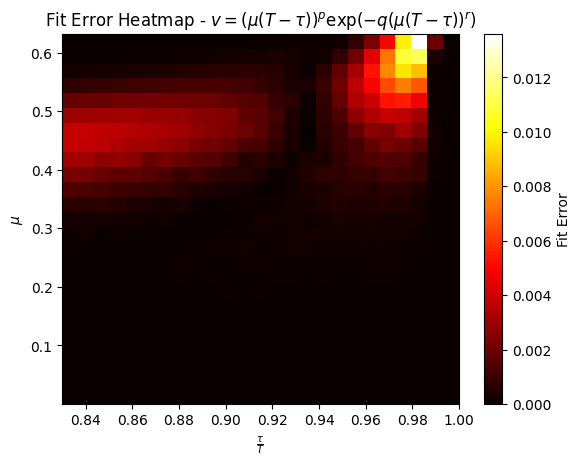

In [ ]:
plt.imshow(np.absolute(y_pred_var.reshape(var_val_grid.shape) - var_val_grid), 
           aspect="auto",
            cmap="hot",
            origin="lower",
            extent=[tau_vals_short[0], tau_vals_short[-1], mu_vals_short[0], mu_vals_short[-1]],)
plt.colorbar(label=r"Fit Error")
plt.xlabel(r"$\frac{\tau} {T}$")
plt.ylabel(r"$\mu$")
plt.title(r"Fit Error Heatmap - $v=(\mu(T-\tau))^p\exp(-q(\mu(T-\tau))^r)$")
plt.show()

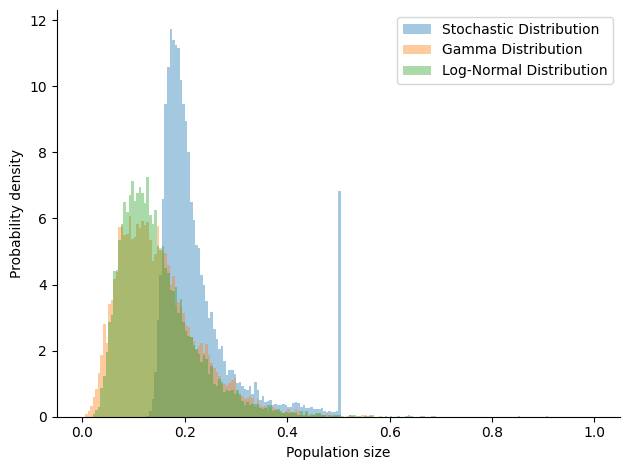

In [ ]:
betaCancer = stochastic_growth(theta, tau, 0.06, gamma, nu, zeta, T, 10000, init)

x = np.linspace(0, 1, 1001)

mean = logistic((mu, tau/T), *params)
variance = bell_guess((mu, tau/T), *params_var)

alpha = mean**2 / variance
beta = mean / alpha
gamma_dist = stats.gamma(a=alpha, scale=beta)
x2 = gamma_dist.rvs(size=10000)

sigma_sq = np.log(1 + (variance / mean**2))
mu_prime = np.log(mean**2 / np.sqrt(variance + mean**2))
sigma = np.sqrt(sigma_sq)

lognorm_dist = stats.lognorm(s=sigma, scale=np.exp(mu_prime))
x3 = lognorm_dist.rvs(size=10000)

fig, ax = plt.subplots()

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.hist(x2, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.hist(x3, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
# plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Stochastic Distribution", "Gamma Distribution", "Log-Normal Distribution"])
sns.despine()
plt.show()

In [ ]:
tau_rel = 0.83

mu_vals = np.linspace(0.005, 0.05, num=50)

c_vals = []
m_vals = []
pos_vals = []

for mu_val in tqdm(mu_vals):
  betaPeak = stochastic_growth(theta, tau_rel*T, mu_val, gamma, nu, zeta, T, 10000, init)

  pos = analytic_calculation(T - tau_rel*T, theta, mu_val, gamma, nu, zeta)

  loc, scale = stats.landau.fit(betaPeak)

  c = scale
  m = loc - (2 * c / np.pi * np.log(c))

  c_vals.append(c)
  m_vals.append(m)
  pos_vals.append(pos[2])

100%|██████████| 50/50 [02:04<00:00,  2.49s/it]


0.83


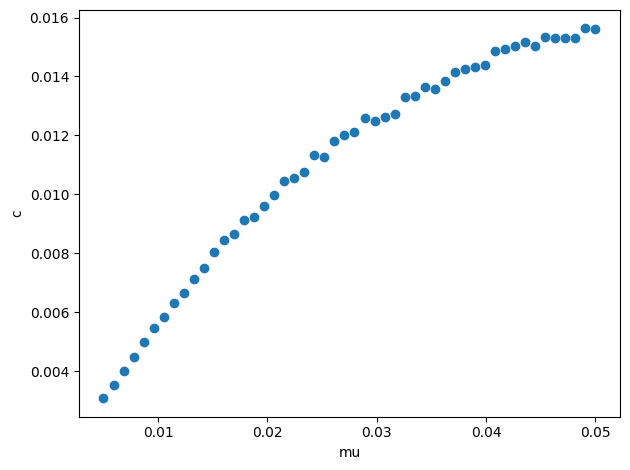

In [ ]:
plt.scatter(mu_vals, c_vals)
plt.xlabel("mu")
plt.ylabel("c")
plt.tight_layout()
print(tau_rel)

In [ ]:
mu_range = np.logspace(-5, -0.5, num=20)
tau_vals = np.linspace(0.83, 0.95, 20)
c_vals_double = np.zeros((len(mu_range), len(tau_vals)))
m_vals_double = np.zeros((len(mu_range), len(tau_vals)))
pos_vals_double = np.zeros((len(mu_range), len(tau_vals)))

In [ ]:
for i in tqdm(range(len(mu_range))):
    for j in range(len(tau_vals)):
        betaPeak = stochastic_growth(theta, tau_vals[j]*T, mu_range[i], gamma, nu, zeta, T, 10000, init)

        pos = analytic_calculation(T - tau_vals[j]*T, theta, mu_range[i], gamma, nu, zeta)

        loc, scale = stats.landau.fit(betaPeak)

        c = scale
        m = loc - (2 * c / np.pi * np.log(c))

        c_vals_double[i, j] = c
        m_vals_double[i, j] = m
        pos_vals_double[i, j] = pos[2]

100%|██████████| 20/20 [12:08<00:00, 36.43s/it]


In [ ]:
f = open('pickles/c_val_grid.pkl', 'wb')
pickle.dump(c_vals_double, f)
f.close()

f = open('pickles/m_val_grid.pkl', 'wb')
pickle.dump(m_vals_double, f)
f.close()

f = open('pickles/pos_val_grid.pkl', 'wb')
pickle.dump(pos_vals_double, f)
f.close()

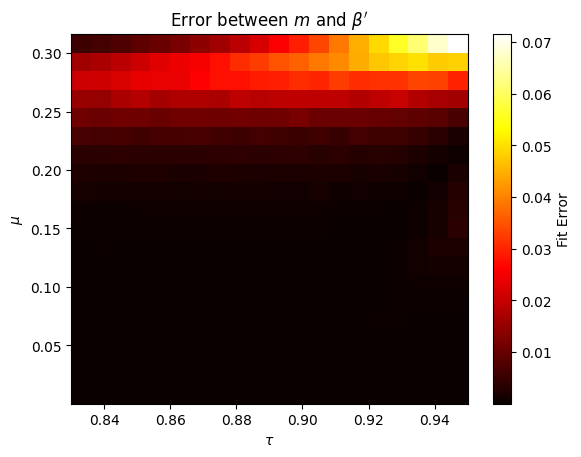

In [ ]:
plt.imshow(
    np.absolute(m_vals_double - pos_vals_double),
    aspect="auto",
    cmap="hot",
    origin="lower",
    extent=[tau_vals[0], tau_vals[-1], mu_range[0], mu_range[-1]],
)
plt.colorbar(label="Fit Error")
plt.xlabel("$\\tau$")
plt.ylabel("$\\mu$")
plt.title("Error between $m$ and $\\beta^\\prime$")
plt.show()

In [ ]:
def log_power(x, a, b, c, d, e):
  mu, tau_rel = x
  tau = T*tau_rel
  return (a*mu**d/(1+c*mu**e))*(T-tau)**b

In [ ]:
tautau, mumu = np.meshgrid(tau_vals, mu_range)
mu_flat = mumu.flatten().T
tau_flat = tautau.flatten().T
results_flat = c_vals_double.flatten().T

xdata = (mu_flat, tau_flat)
p0 = (2, 0.9, 2, 0.5, 0.5)

params, cov = curve_fit(log_power, xdata, results_flat, p0=p0)

a, b, c, d, e = params
print(f"a={a}, b={b}, c={c}, d={d}, e={e}")

a=1.934587603554332, b=-1.1171569490321491, c=38.17552815219582, d=0.9190149266208256, e=1.8994223670707864


In [ ]:
y_pred = log_power(xdata, *params)

# Calculate R^2 score
ss_res = np.sum((results_flat - y_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((results_flat - np.mean(results_flat)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

print(f"R^2 = {r2:.4f}")

R^2 = 0.9182


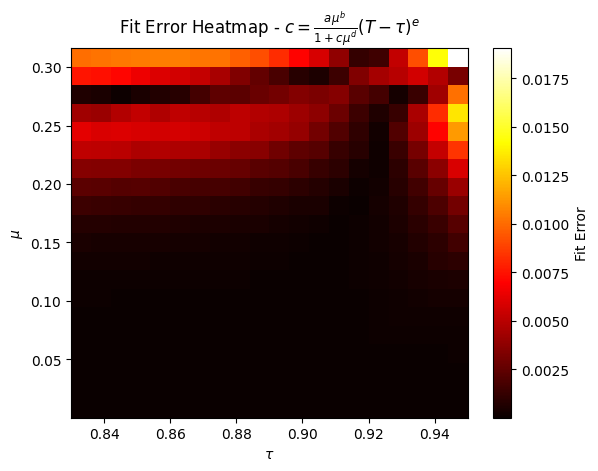

In [ ]:
plt.imshow(
    np.absolute(y_pred.reshape(c_vals_double.shape) - c_vals_double),
    aspect="auto",
    cmap="hot",
    origin="lower",
    extent=[tau_vals[0], tau_vals[-1], mu_range[0], mu_range[-1]],
)
plt.colorbar(label="Fit Error")
plt.xlabel("$\\tau$")
plt.ylabel("$\\mu$")
plt.title("Fit Error Heatmap - $c=\\frac{a\\mu^b}{1+c\\mu^d}(T-\\tau)^e$")
plt.show()

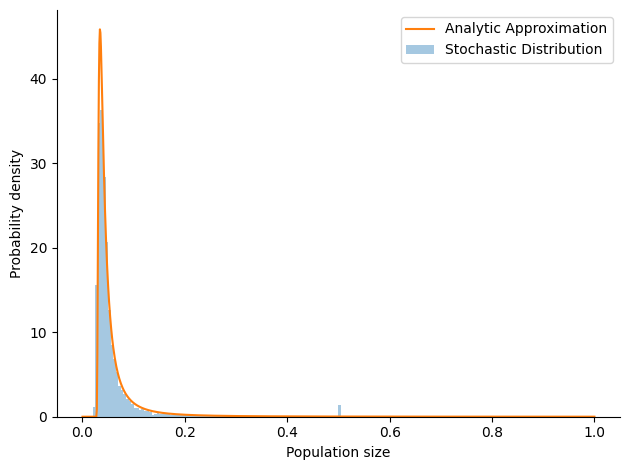

In [ ]:
mu = 0.012

betaCancer = stochastic_growth(theta, tau, mu, gamma, nu, zeta, T, 10000, init)

x = np.linspace(0, 1, 1001)
pdf = np.exp(demeth_homo_init_lpdf(x, theta, mu, tau, T))

fig, ax = plt.subplots()

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()

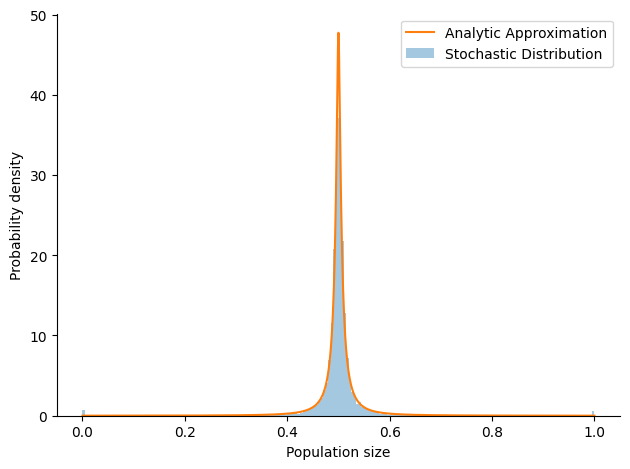

In [ ]:
betaCancer = stochastic_growth(theta, tau, 1e-12, 1e-12, 0.012, 0.012, T, 10000, 1)

x = np.linspace(0, 1, 1001)
pdf = np.exp(meth_hetero_init_lpdf(x, theta, 0.012, 0.012, tau, T))

fig, ax = plt.subplots()


plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()

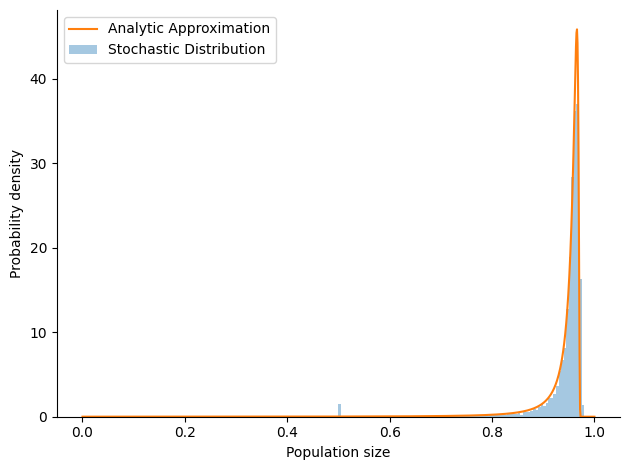

In [ ]:
mu = 0.012

betaCancer = stochastic_growth(theta, tau, 1e-12, 0.012, 1e-12, 1e-12, T, 10000, 2)

x = np.linspace(0, 1, 1001)
pdf = np.exp(meth_homo_init_lpdf(x, theta, 0.012, tau, T))

fig, ax = plt.subplots()

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()

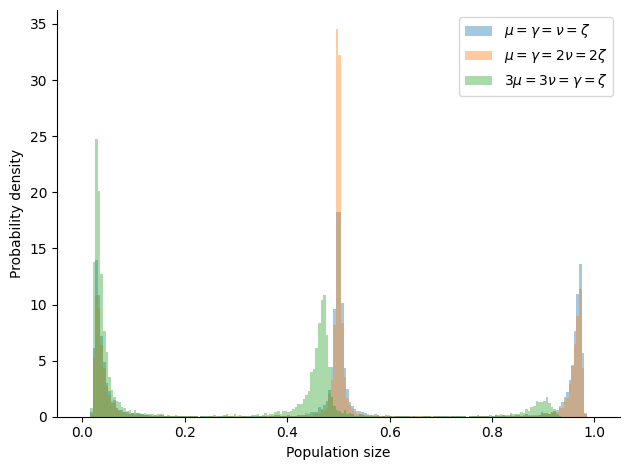

In [ ]:
init = None

betaCancer_even = stochastic_growth(theta, tau, 0.01, 0.01, 0.01, 0.01, T, 10000, init)
betaCancer_smallnuzeta = stochastic_growth(theta, tau, 0.01, 0.01, 0.005, 0.005, T, 10000, init)
betaCancer_largegammazeta = stochastic_growth(theta, tau, 0.01, 0.03, 0.01, 0.03, T, 10000, init)

fig, ax = plt.subplots()

plt.hist(betaCancer_even, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.hist(betaCancer_smallnuzeta, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.hist(betaCancer_largegammazeta, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=[r"$\mu=\gamma=\nu=\zeta$", r"$\mu=\gamma=2\nu=2\zeta$", r"$3\mu=3\nu=\gamma=\zeta$"])
sns.despine()
plt.show()

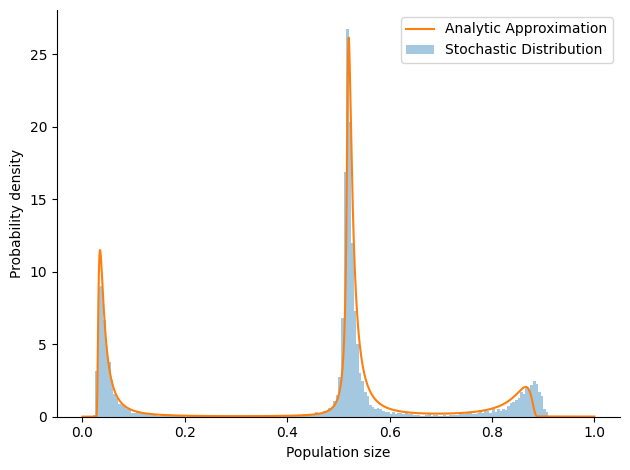

In [ ]:
mu = 0.012
gamma = 0.04
nu = 0.02
zeta = 0.006

betaCancer = stochastic_growth(theta, tau, mu, gamma, nu, zeta, T, 10000, init)

x = np.linspace(0, 1, 1001)
pdf = np.exp(combined_lpdf(x, theta, tau, mu, gamma, nu, zeta, T))

fig, ax = plt.subplots()

plt.hist(betaCancer, bins = np.linspace(0, 1, 201), 
         alpha = 0.4, density = True)
plt.plot(x, pdf)
plt.xlabel('Population size')
plt.ylabel('Probability density')
plt.tight_layout()
plt.legend(labels=["Analytic Approximation", "Stochastic Distribution"])
sns.despine()
plt.show()